In [12]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import scipy.spatial
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from time import time
import scipy.stats as stats
#from sklearn.utils.fixes import loguniform

import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix 

In [3]:
from scipy.io import loadmat
mat = loadmat("Project Datasets/thyroidTrain.mat")
#dataf =  pd.DataFrame(mat)
# Load data X and y 
X = np.transpose(mat["trainThyroidInput"]).T # 
y = np.transpose(mat["trainThyroidOutput"]).T #
print("X shape:", X.shape)
print("y shape:", y.shape)
yres = 1*y[:,0] + 2*y[:,1] + 4*y[:,2] # covert output of 3 coulumn into 2 coulumn
yres = yres.reshape(len(y),1)
print("yres.shape:", yres.shape)

# Load Xtest
Xtest = np.transpose(mat["testThyroidInput"]).T # 
print("Xtest shape:", Xtest.shape)

#sns.pairplot(dataf,hue='class',palette='Dark2')

X shape: (5000, 21)
y shape: (5000, 3)
yres.shape: (5000, 1)
Xtest shape: (2200, 21)


<IPython.core.display.Javascript object>


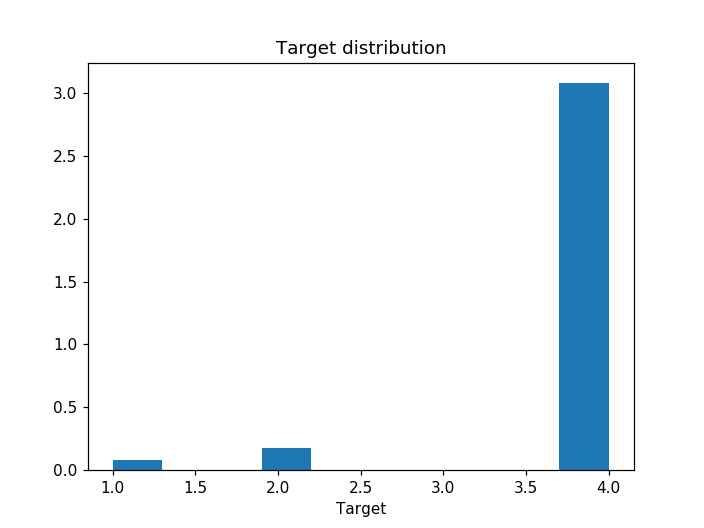

Text(0.5, 1.0, 'Target distribution')

In [4]:
import matplotlib
from distutils.version import LooseVersion

# `normed` is being deprecated in favor of `density` in histograms
if LooseVersion(matplotlib.__version__) >= '2.1':
    density_param = {'density': True}
else:
    density_param = {'normed': True}

from sklearn.preprocessing import QuantileTransformer, quantile_transform
#y_trans = quantile_transform(y,n_quantiles=100,output_distribution='normal',copy=True).squeeze()

#f, (ax0, ax1) = plt.subplots(1, 2)
f, ax0 = plt.subplots()
ax0.hist(yres, bins=10, **density_param)
ax0.set_ylabel('')
ax0.set_xlabel('Target')
ax0.set_title('Target distribution')

In [5]:
#Normalization 
mu = np.mean(X, axis=0)
std = np.std(X)
X_normalized = (X-mu)/std

Xtest_normalized = (Xtest-mu)/std

Xall.shape:(7200, 21)
X_pca.shape>>>> (7200, 20)


<IPython.core.display.Javascript object>


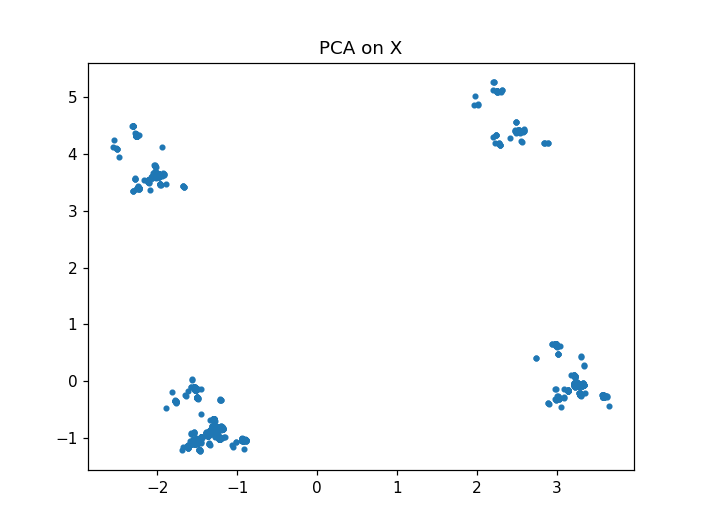

In [6]:
# PCA 
from sklearn.decomposition import PCA

#Before doing PCA, combine train, validation and test input data
Xall = X_normalized ###
Xall = np.concatenate([Xall, Xtest_normalized], axis=0) ###
print("Xall.shape:{}".format(Xall.shape))

#pca to get principle features
pca = PCA(n_components='mle')
X_pca = pca.fit_transform(Xall)
print("X_pca.shape>>>>", X_pca.shape)

fig, ax = plt.subplots()
ax.plot(X_pca[:,0], X_pca[:,1], '.')
ax.set_title("PCA on X")

fig.show()

In [ ]:
import pandas as pd
import seaborn as sns
Xdf = pd.DataFrame(X_pca[:,:4])
sns.pairplot(Xdf)

In [7]:
#Split (training, validation) and test datasets
Xte = X_pca[-Xtest.shape[0]:,:]
print("Xte.shape:{}".format(Xte.shape))
Xrem = X_pca[:-Xtest.shape[0],:]

#Split training & validation datasets
from sklearn.model_selection import train_test_split
Xtr, Xva, ytr, yva = train_test_split(Xrem, yres, train_size=0.8, random_state=1)

#Xtr = X[int(Xrem.shape[0]/5):,:]
#ytr = yres[int(yres.shape[0]/5):,:]
#Xva = X[:int(Xrem.shape[0]/5),:]
#yva = yres[:int(yres.shape[0]/5),:]

#print("Xtrain.shape:{}, ytrain.shape:{}, Xval.shape:{}, yval.shape:{}".format(Xtrain.shape, ytrain.shape, Xval.shape, yval.shape))
print("Xtr.shape:{}, ytr.shape:{}, Xva.shape:{}, yva.shape:{}".format(Xtr.shape, ytr.shape, Xva.shape, yva.shape))

Xte.shape:(2200, 20)
Xtr.shape:(4000, 20), ytr.shape:(4000, 1), Xva.shape:(1000, 20), yva.shape:(1000, 1)


C:\Users\veena\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [8]:
Xtrain = Xtr
ytrain = ytr
Xval = Xva
yval = yva
Xtest = Xte

In [13]:
##SVM Classifier
print("Using SVM Classifier:\n")
svclf = SVC(kernel="linear", C=0.025)
svclf.fit(Xtrain, np.ravel(ytrain))

print('Predictions on validation data: \n')
print ('*******************************************\n')
PredictedOutcome = svclf.predict(Xval)
#print(PredictedOutcome)
print ('\n*******************************************')

Number_of_Correct_Predictions = len([i for i, j in zip(PredictedOutcome, yval) if i == j])

print('Number of Correct Predictions:', Number_of_Correct_Predictions, 'out of', len(PredictedOutcome),
      'Number of Test Data')
print('Accuracy of Prediction in Percentage:', (Number_of_Correct_Predictions/float(len(PredictedOutcome)))*100, '%')

print("\n--------------------------------------------------------------\n")

scores = cross_val_score(svclf, Xrem, np.ravel(yres), cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

print(confusion_matrix(yval,PredictedOutcome))
print(classification_report(yval,PredictedOutcome))

Using SVM Classifier:

Predictions on validation data: 

*******************************************


*******************************************
Number of Correct Predictions: 923 out of 1000 Number of Test Data
Accuracy of Prediction in Percentage: 92.30000000000001 %

--------------------------------------------------------------

Accuracy: 0.93 (+/- 0.00)
[[  1   0  20]
 [  0   0  57]
 [  0   0 922]]
              precision    recall  f1-score   support

           1       1.00      0.05      0.09        21
           2       0.00      0.00      0.00        57
           4       0.92      1.00      0.96       922

   micro avg       0.92      0.92      0.92      1000
   macro avg       0.64      0.35      0.35      1000
weighted avg       0.87      0.92      0.89      1000



C:\Users\veena\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\veena\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\veena\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [14]:
def plot_confusion_mat(classifier, X_test, y_test):
    from sklearn.metrics import plot_confusion_matrix

    class_names = ['label1', 'label2', 'label3']#iris.target_names
    # Plot non-normalized & normalized confusion matrix
    titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(classifier, X_test, y_test,
                                     display_labels=class_names,
                                     cmap=plt.cm.Blues,
                                     normalize=normalize)
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)

    plt.show()

In [15]:
plot_confusion_mat(svclf, Xval, yval)

ImportError: cannot import name 'plot_confusion_matrix' from 'sklearn.metrics' (C:\Users\veena\Anaconda3\lib\site-packages\sklearn\metrics\__init__.py)

In [ ]:

#import matplotlib.pyplot as pplt
from sklearn.model_selection import validation_curve

param_range = np.arange(0.001,0.01,0.001)
train_scores, test_scores = validation_curve(
    SVC(), Xrem, np.ravel(yres), param_name="gamma", param_range=param_range,
    scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig, pplt = plt.subplots()
plt.title("Validation Curve with SVM")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
fig.show()

In [ ]:
#----Hyperparameter tuning-----
# specify parameters and distributions to sample from
#param_dist = {'kernel': ['linear'], 'C': np.arange(0.01,1,0.01)}
param_dist = {'C': np.arange(10, 200, 10), 'gamma': np.arange(0.001,0.01,0.001),'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(svclf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(Xtrain, np.ravel(ytrain))
best_params = random_search.best_params_
print("RandomizedSearchCV took %.2f seconds for %d candidates parameter settings." % ((time() - start), n_iter_search))
#report(random_search.cv_results_)

# run grid search
#grid_search = GridSearchCV(svclf, param_dist, cv=5)
#start = time()
#grid_search.fit(Xtrain, np.ravel(ytrain))
#best_params = grid_search.best_params_
#print("GridSearchCV took %.2f seconds" % (time() - start))
print(best_params)

#-------Update the estimator----------
svclf = SVC(kernel=best_params['kernel'], C=best_params['C'], gamma=best_params['gamma'])
svclf.fit(Xtrain, np.ravel(ytrain))
PredictedOutcome = random_search.predict(Xval)#svclf.predict(Xval)
#--------Cross validation-------
scores = cross_val_score(svclf, Xrem, np.ravel(yres), cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

print(confusion_matrix(yval,PredictedOutcome))
print(classification_report(yval,PredictedOutcome))

In [ ]:
##Decision Tree Classifier
print("Using Decision Tree Classifier:\n")
dtclf = DecisionTreeClassifier(max_depth=5)
dtclf.fit(Xtrain, np.ravel(ytrain))

print('Predictions on validation data: \n')
print ('*******************************************\n')
PredictedOutcome = dtclf.predict(Xval)
#print(PredictedOutcome)
print ('\n*******************************************')

Number_of_Correct_Predictions = len([i for i, j in zip(PredictedOutcome, yval) if i == j])

print('Number of Correct Predictions:', Number_of_Correct_Predictions, 'out of', len(PredictedOutcome),
      'Number of Test Data')
print('Accuracy of Prediction in Percentage:', (Number_of_Correct_Predictions/float(len(PredictedOutcome)))*100, '%')

print("\n--------------------------------------------------------------\n")

scores = cross_val_score(dtclf, Xrem, np.ravel(yres), cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

print(confusion_matrix(yval,PredictedOutcome))
print(classification_report(yval,PredictedOutcome))

In [ ]:

#import matplotlib.pyplot as pplt
from sklearn.model_selection import validation_curve

param_range = np.arange(1, 50, 1)
train_scores, test_scores = validation_curve(
    DecisionTreeClassifier(), Xrem, np.ravel(yres), param_name="max_depth", param_range=param_range,
    scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig, pplt = plt.subplots()
plt.title("Validation Curve with DecisionTreeClassifier")
plt.xlabel("max_depth")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
fig.show()

In [ ]:
#----Hyperparameter tuning-----
# specify parameters and distributions to sample from
param_dist = {'max_depth':np.arange(5,20,5)#, 'min_samples_split': np.arange(0.1, 1.0, 0.10), 'min_samples_leaf': np.arange(0.1, 0.5, 0.1)
              , 'criterion':['gini', 'entropy'], 'ccp_alpha': [0.01, 0.03, 0.05]}

# run randomized search
#n_iter_search = 20
#random_search = RandomizedSearchCV(dtclf, param_distributions=param_dist, n_iter=n_iter_search)

#start = time()
#random_search.fit(Xtrain, np.ravel(ytrain))
#best_params = random_search.best_params_
#print("RandomizedSearchCV took %.2f seconds for %d candidates parameter settings." % ((time() - start), n_iter_search))
#report(random_search.cv_results_)
#print(best_params)

# run grid search
grid_search = GridSearchCV(dtclf, param_dist, cv=5)
start = time()
grid_search.fit(Xtrain, np.ravel(ytrain))
best_params = grid_search.best_params_
print("GridSearchCV took %.2f seconds" % (time() - start))
print(best_params)
PredictedOutcome = grid_search.predict(Xval)

#-------Update the estimator----------
dtclf = DecisionTreeClassifier(max_depth=best_params['max_depth'], criterion=best_params['criterion'], ccp_alpha=best_params['ccp_alpha'])

#--------Cross validation-------
scores = cross_val_score(dtclf, Xrem, np.ravel(yres), cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

print(confusion_matrix(yval,PredictedOutcome))
print(classification_report(yval,PredictedOutcome))

In [ ]:
##MLPClassifier
print("Using MLP Classifier:\n")
mlpclf = MLPClassifier(alpha=1, max_iter=2000, early_stopping=True)

mlpclf.fit(Xtrain, np.ravel(ytrain))

print('Predictions on validation data: \n')
print ('*******************************************\n')
PredictedOutcome = mlpclf.predict(Xval)
#print(PredictedOutcome)
print ('\n*******************************************')

Number_of_Correct_Predictions = len([i for i, j in zip(PredictedOutcome, yval) if i == j])

print('Number of Correct Predictions:', Number_of_Correct_Predictions, 'out of', len(PredictedOutcome),
      'Number of Test Data')
print('Accuracy of Prediction in Percentage:', (Number_of_Correct_Predictions/float(len(PredictedOutcome)))*100, '%')

print("\n--------------------------------------------------------------\n")

scores = cross_val_score(mlpclf, Xrem, np.ravel(yres), cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

print(confusion_matrix(yval,PredictedOutcome))
print(classification_report(yval,PredictedOutcome))

In [ ]:

#import matplotlib.pyplot as pplt
from sklearn.model_selection import validation_curve

param_range = np.arange(0.0002,0.001,0.0002)
train_scores, test_scores = validation_curve(
    MLPClassifier(max_iter=1000, verbose=True), Xrem, np.ravel(yres), param_name="alpha", param_range=param_range,
    scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig, pplt = plt.subplots()
plt.title("Validation Curve with DecisionTreeClassifier")
plt.xlabel("max_depth")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
fig.show()

In [ ]:
#----Hyperparameter tuning-----
# specify parameters and distributions to sample from
param_dist = {'verbose':[True], 'early_stopping':[True],'alpha':np.arange(0.0002,0.001,0.0002), 'hidden_layer_sizes':[(30,30,30),(50,50,50),(70,70,70)], 'learning_rate_init':[0.001,0.01,0.1],'max_iter':np.arange(1000,2000,1000)}

# run randomized search
#n_iter_search = 20
#random_search = RandomizedSearchCV(mlpclf, param_distributions=param_dist, n_iter=n_iter_search)

#start = time()
#random_search.fit(Xtrain, np.ravel(ytrain))
#best_params = random_search.best_params_
#print("RandomizedSearchCV took %.2f seconds for %d candidates parameter settings." % ((time() - start), n_iter_search))
#report(random_search.cv_results_)
#print(best_params)

# run grid search
grid_search = GridSearchCV(mlpclf, param_dist, cv=5)
start = time()
grid_search.fit(Xtrain, np.ravel(ytrain))
best_params = grid_search.best_params_
print("GridSearchCV took %.2f seconds" % (time() - start))
print(best_params)

#-------Update the estimator----------
mlpclf = MLPClassifier(alpha=best_params['alpha'], max_iter=best_params['max_iter'])

#--------Cross validation-------
scores = cross_val_score(mlpclf, Xrem, np.ravel(yres), cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

PredictedOutcome = grid_search.predict(Xval)
print(confusion_matrix(yval,PredictedOutcome))
print(classification_report(yval,PredictedOutcome))

In [ ]:
##Knn Classifier
print("Using Knn Classifier:\n")
knnclf = KNeighborsClassifier()# by default, n_neighbors=5, p=2(i.e. minkowski_distance)
knnclf_params = knnclf.get_params()
print("knnclf_params: ", knnclf_params)
knnclf.fit(Xtrain, np.ravel(ytrain))
print("\n")
print('Predictions on validation data: \n')
print ('*******************************************\n')
PredictedOutcome = knnclf.predict(Xval)
#print(PredictedOutcome)
print ('\n*******************************************')

Number_of_Correct_Predictions = len([i for i, j in zip(PredictedOutcome, yval) if i == j])

print('Number of Correct Predictions:', Number_of_Correct_Predictions, 'out of', len(PredictedOutcome),
      'Number of Test Data')
print('Accuracy of Prediction in Percentage:', (Number_of_Correct_Predictions/float(len(PredictedOutcome)))*100, '%')

print("\n--------------------------------------------------------------\n")

scores = cross_val_score(knnclf, Xrem, np.ravel(yres), cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

print(confusion_matrix(yval,PredictedOutcome))
print(classification_report(yval,PredictedOutcome))

In [ ]:

#import matplotlib.pyplot as pplt
from sklearn.model_selection import validation_curve

param_range = np.arange(3,10,2)
train_scores, test_scores = validation_curve(
    KNeighborsClassifier(), Xrem, np.ravel(yres), param_name='n_neighbors', param_range=param_range,
    scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

fig, pplt = plt.subplots()
plt.title("Validation Curve with KNeighborsClassifier")
plt.xlabel("max_depth")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
fig.show()

In [ ]:
#----Hyperparameter tuning-----
# specify parameters and distributions to sample from
param_dist = {'n_neighbors':np.arange(3,21,2), 'p':[1,2], 'weights':['distance']}

# run randomized search
#n_iter_search = 20
#random_search = RandomizedSearchCV(knnclf, param_distributions=param_dist, n_iter=n_iter_search)

#start = time()
#random_search.fit(Xtrain, np.ravel(ytrain))
#best_params = random_search.best_params_
#print("RandomizedSearchCV took %.2f seconds for %d candidates parameter settings." % ((time() - start), n_iter_search))
#report(random_search.cv_results_)
#print(best_params)

# run grid search
grid_search = GridSearchCV(knnclf, param_dist, cv=5)
start = time()
grid_search.fit(Xtrain, np.ravel(ytrain))
best_params = grid_search.best_params_
print("GridSearchCV took %.2f seconds" % (time() - start))
print(best_params)

#-------Update the estimator----------
knnclf = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'], p=best_params['p'])

#--------Cross validation-------
scores = cross_val_score(knnclf, Xrem, np.ravel(yres), cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

PredictedOutcome = grid_search.predict(Xval)
print(confusion_matrix(yval,PredictedOutcome))
print(classification_report(yval,PredictedOutcome))

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()

eclf = VotingClassifier(
     estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)],
     voting='hard')
eclf.fit(Xtrain, np.ravel(ytrain))
for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):
    scores = cross_val_score(clf, X, np.ravel(yres), scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

In [ ]:
val_preds = knnclf.predict(Xval)
test_preds = knnclf.predict(Xtest)
fig, ax = plt.subplots()
ax.set_title("Test Predictions")
ax.set_xlabel("Samples")
ax.set_ylabel("Predictions")
ax.plot(ytrain[:200], 'blue', label='Training output')
ax.plot(yval[:200], 'green', label='Validation output')
ax.plot(test_preds[:200], 'red', label='Test output')
plt.legend()
fig.show()

In [ ]:
y_predi = eclf.predict(Xval)
y_predi_real = eclf.predict(Xtest)

fig, ax = plt.subplots()
ax.plot(ytrain[0:1000], label = "training output", color = "red", marker='.')
ax.plot(y_predi[0:1000], label = "validation output", color = "blue", marker='+')
ax.plot(y_predi_real[0:1000], label = "testing output", color = "green", marker='x')
plt.legend()
plt.show()


